# Supernova Signal - WFSim

Create waveform simulator instruction file based on a supernova model.

**ToDo**<br>
Recoil spectra sampling is pretty sparse and sampling from that gives discrete values. Interpolate the final spectra and sample from that.

## Table of Contents
- None

In [1]:
import numpy as np
import click
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import multihist as mh
import multimessenger.supernova as sn

*** Detector definition message ***
You are currently using the default XENON10 template detector.



In [2]:
M30sn_model  = sn.Supernova_Models.SN_LightCurve()
M30sn_model.load_model_from_db(progenitor_mass = 30, metallicity= 0.02, time_of_revival = 100,)
M30sn_model.get_recoil_spectra1D(rec_en = np.linspace(0,20,35))
M30sn_model.get_recoil_spectra2D()

Retrieving object /dali/lgrandi/melih/mma/data/Xenon_30-M_-0.02-Z_100-t_dist10.p
Object was found! 
To save manually: save_object(filename, update=True)

Retrieving object /dali/lgrandi/melih/mma/data/Xenon_30-M_-0.02-Z_100-t_dist10_Er0.0-20.0-35_t0-0-tf-10_1D.p
Retrieving object /dali/lgrandi/melih/mma/data/Xenon_30-M_-0.02-Z_100-t_dist10_Er0.0-15.3-27_tstep1_dist10_2D.p


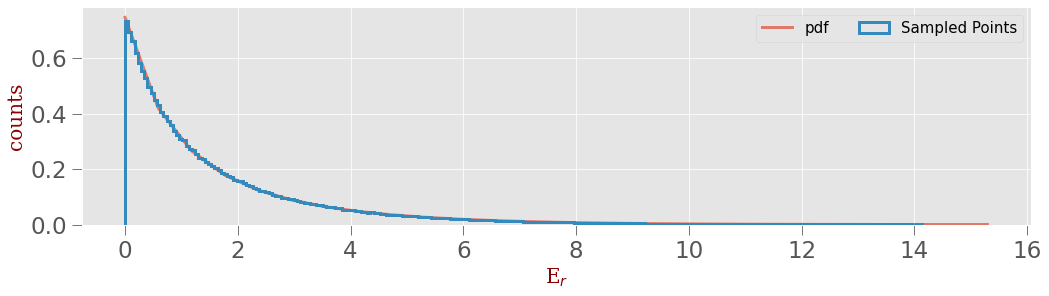

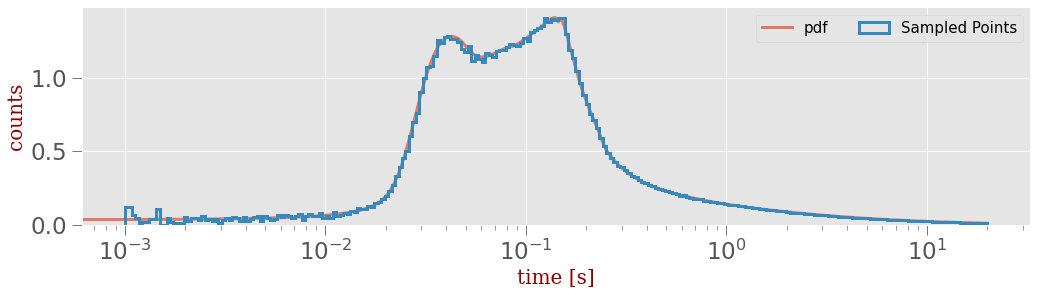

In [3]:
plotter = sn.Plotter(M30sn_model)
fig, ax, samples = plotter.plot_sampled_energies()
plotter.plot_sampled_energies(x='time', xscale='log');

#### Object attributes

In [3]:
tot_rates1D = M30sn_model.total_rate1D # integrated(summed) between 0-10s 
tot_rates2D = M30sn_model.total_rate2D
recoil_energy_bins = M30sn_model.recoil_en
timebins = M30sn_model.t
nu_energies = M30sn_model.mean_E
rates_Er, rates_t = M30sn_model._get_1Drates_from2D()

The `sample_from_recoil_spectrum` can return 0 values, which might be a **problem**, as there would be no signal at these times (or worse, at negative times.)

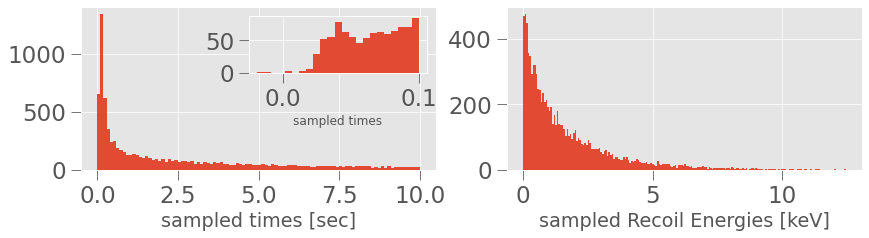

In [35]:
sample_t = sn.sample_from_recoil_spectrum(x='time',N_sample=10000)
sample_E = sn.sample_from_recoil_spectrum(N_sample=10000)
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(14,3))
ax1.hist(sample_t, range=(min(sample_t), 10), bins=100);

axins = inset_axes(ax1, width="50%", height="35%", loc='upper right')
axins.hist(sample_t, range=(min(sample_t), 0.1), bins=23);
axins.set_xlabel('sampled times', fontsize=12)

ax1.set_xlabel('sampled times [sec]');
ax2.hist(sample_E, bins=200);
ax2.set_xlabel('sampled Recoil Energies [keV]');

Make a time versus recoil energy 2d bins

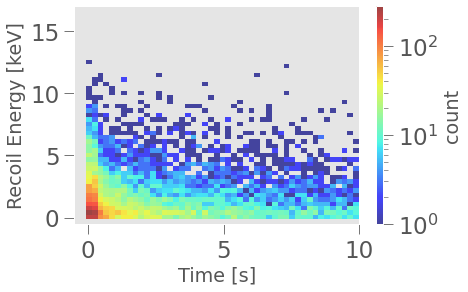

In [36]:
kwargs = dict(norm=LogNorm(), bins=(np.linspace(-0.5, 10, 50),
                                    np.linspace(-0.5, 17, 50)))
mh_cut = mh.Histdd(sample_t, sample_E, **kwargs)

mh_cut.plot(log_scale=True,
            cblabel='count',
            cmap=plt.get_cmap('jet'),
            alpha=0.7,  colorbar_kwargs=dict(orientation="vertical", pad=0.05,
                                             aspect=30, fraction=0.1));
plt.ylabel('Recoil Energy [keV]')
plt.xlabel('Time [s]');

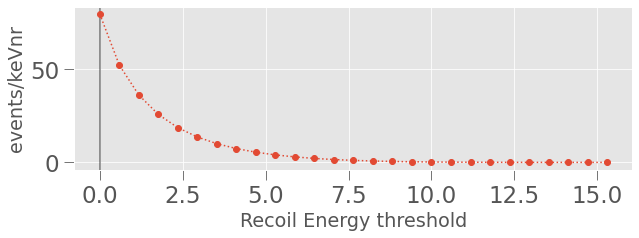

In [7]:
E_thr, rec_bins = sn.get_rates_above_threshold(rates_Er['Total'], recoil_energy_bins)
plt.figure(figsize=(10,3))
plt.axvline(0, color='k', alpha=0.5);
plt.plot(rec_bins, E_thr*4.7, marker='o', ls=':');
plt.ylabel('events/keVnr');
plt.xlabel('Recoil Energy threshold');

Take the fiducial volume as 4.7 tonnes for now. There should be ~75 events in total.

---
## Import WFSim

In [4]:
import wfsim, strax, straxen, cutax, ntauxfiles
straxen.print_versions(('strax','straxen','cutax','wfsim', 'multimessenger', 'ntauxfiles'),)

,module,version,path,git
0,python,3.8.12,/opt/XENONnT/anaconda/envs/XENONnT_development...,None
1,strax,1.2.0,/home/melih/.local/lib/python3.8/site-packages...,None
2,straxen,1.6.0,/home/melih/.local/lib/python3.8/site-packages...,None
3,cutax,1.5.0,/home/melih/software/cutax/cutax,branch:master | f34325d
4,wfsim,0.5.13,/home/melih/software/WFSim/wfsim,branch:jianyang_wfsim_tests | 30bee9d
5,multimessenger,1.1.0,/home/melih/software/multimessenger/multimesse...,branch:making_package | cc20fb7
6,ntauxfiles,0.3.0,/home/melih/software/private_nt_aux_files/ntau...,branch:SE_shape_matching | ec33fde


In [5]:
wfsim.instruction_dtype

[(('Waveform simulator event number.', 'event_number'), numpy.int32),
 (('Quanta type (S1 photons or S2 electrons)', 'type'), numpy.int8),
 (('Time of the interaction [ns]', 'time'), numpy.int64),
 (('X position of the cluster [cm]', 'x'), numpy.float32),
 (('Y position of the cluster [cm]', 'y'), numpy.float32),
 (('Z position of the cluster [cm]', 'z'), numpy.float32),
 (('Number of quanta', 'amp'), numpy.int32),
 (('Recoil type of interaction.', 'recoil'), numpy.int8),
 (('Energy deposit of interaction', 'e_dep'), numpy.float32),
 (('Eventid like in geant4 output rootfile', 'g4id'), numpy.int32),
 (('Volume id giving the detector subvolume', 'vol_id'), numpy.int32),
 (('Local field [ V / cm ]', 'local_field'), numpy.float64),
 (('Number of excitons', 'n_excitons'), numpy.int32)]

Ricardo's script for instruction generation https://github.com/XENONnT/analysiscode/blob/master/S2_shape_width/simulation/make_submit_files.py

The `E_thr` gives 'total' number of events above each threshold, i.e. `E_thr[0]` is the maximum amount of total events you can get when you set the threshold to zero (`rec_bins[0]`) 

In [8]:
nr_SNevents_perton = E_thr[0]
nr_SNevents_perton

16.95652182007576

### WFSim Instructions
There is a helper function in `sn.sn_utils.instructions_SN()` to create instruction files. <br>
You can specify the total number of events you want in the simulation ($N$), and the total number of events from a single supernova ($m$). In this case, it samples $m$ recoil energies from the recoil spectrum, and $m$ arrival times. Once the $m$ number of events is sampled, it shifts 10 seconds, and samples $m$ more events until the total is $N$ number of events. <br>
The result should be int($M/n$) supernova signals in the simulations, each separated by ~10 seconds. Thus, one can analyze the peak properties, and keep the individual times separate. <br>
If you do not want this shift, you can set $M=n$, however, since the time distribution is in a very narrow range, this will likely cause issue with chunks.

You can also create instructions to simulate raw Supernova signal by passing `sn.sn_utils.instructions_SN(total_event, signle_SN, single=True)` note that this is usually ~17 events _per tonne_ <br>

It is also possible to include, `below_cathode` events.

In [40]:
instructions = sn.sn_utils.instructions_SN(100_000, nr_SNevents_perton, dump_csv=True, filename='SN_wfsim_test1.csv')

generating instructions from nest:   0%|          | 0/100000 [00:00<?, ?it/s]

Saved in -> /dali/lgrandi/melih/sn_wfsim/instructions/SN_wfsim_test1.csv


In [28]:
single_instr = sn.sn_utils.instructions_SN(1, nr_SNevents_perton, single=True, dump_csv=True, filename='SN_wfsim_instructions_single.csv')

generating instructions from nest:   0%|          | 0/80 [00:00<?, ?it/s]

Saved in -> /dali/lgrandi/melih/sn_wfsim/instructions/SN_wfsim_instructions_single.csv


In [10]:
# sn_utils.clean_repos('SN_wfsim_instructions.csv')
# sn_utils.see_repos()

### Next, we create WFSim simulations

when creating WFSim instruction, nestpy requires several detector properties. These detector-specific properties, and some more configurations such as paths are stored in a `config` file. The keys of this file can be displayed using; `sn.sn_utils.display_config()`

In [6]:
sn.sn_utils.display_config()

      xenonnt       
field
volume
lxe_density
drift_field
---------------
       paths        
imgs
data
---------------
       strax        
exclude_tags
---------------
       wfsim        
instruction_path
logs_path
strax_data_path
---------------


We can create a single SN signal here, but to create `SN_wfsimdata_100k` it is better to submit a job. See `sn_batch-job.job` and `wfsim_batch.py`. <br>
Once, created it is stored.

In [8]:
sn.sn_utils.see_repos()


 >>Instructions

SN_wfsim_test1.csv
SN_wfsim_instructions_single.csv
SN_wfsim_instructions_100k.csv

 >>Logs

wfsim_high-stat.out
wfsim_high-stat.err

 >>Existing data

SN_wfsimdata_100k-truth-my4gxfhotd
SN_wfsimdata_100k-raw_records_he-my4gxfhotd
SN_wfsimdata_100k-raw_records_aqmon-my4gxfhotd
SN_wfsimdata_100k-raw_records-my4gxfhotd
SN_wfsimdata_100k-peaklets-bie4dbe7uq
SN_wfsimdata_100k-peaklet_classification-zx5hnlbcxi
SN_wfsimdata_100k-peak_proximity-ms2awbcenc
SN_wfsimdata_100k-peak_proximity-kyxbh64kup
SN_wfsimdata_100k-peak_positions_mlp-trboz276tl
SN_wfsimdata_100k-peak_positions_gcn-kjccspojaq
SN_wfsimdata_100k-peak_positions_cnn-gzc3ptv4wd
SN_wfsimdata_100k-peak_basics-qx25yaesdk
SN_wfsimdata_100k-merged_s2s-wb6turax6q
SN_wfsimdata_100k-lone_hits-bie4dbe7uq
SN_wfsimdata_100k-event_positions-4fnlquguxu
SN_wfsimdata_100k-event_positions-27zms63dso
SN_wfsimdata_100k-event_info-hbuc3jrqss
SN_wfsimdata_100k-event_info-b2pyr5zdyi
SN_wfsimdata_100k-event_basics-fpmdg4cuhd
SN_wfsimd

In [9]:
import os

st = straxen.contexts.xenonnt_simulation(
            wfsim_registry='RawRecordsFromFaxNT',
            cmt_run_id_sim="026000",
            cmt_run_id_proc="026000",
            cmt_version='global_v7',
            fax_config='/home/melih/software/private_nt_aux_files/sim_files/fax_config_nt_sr0_v0.json',
            overwrite_from_fax_file_sim=True,
            overwrite_from_fax_file_proc=True,
            output_folder=sn.config["wfsim"]["strax_data_path"])

# st = cutax.contexts.xenonnt_sim_SR0v0_cmt_v7(output_folder=f'{sn.config["wfsim"]["strax_data_path"]}')
single_SN_path = os.path.join(sn.config["wfsim"]["instruction_path"], "SN_wfsim_instructions_single.csv")
st.set_config(dict(fax_file=single_SN_path))

In [10]:
# ntauxfiles.get_sim_file('fax_config_nt_sr0_v0.json')['s2_time_model']

In [11]:
# import pandas as pd
# single_SN_path = os.path.join(sn.config["wfsim"]["instruction_path"], "SN_wfsim_instructions_single.csv")
# df = pd.read_csv(single_SN_path)

In [12]:
run_id = "SN_single"

truth = st.get_df(run_id,'truth')
peak_basics = st.get_df(run_id, 'peak_basics')
event_info = st.get_df(run_id, 'event_info')

Loading truth: |          | 0.00 % [00:00<?]

Loading peak_basics: |          | 0.00 % [00:00<?]

Loading event_info: |          | 0.00 % [00:00<?]

In [13]:
for run in [run_id]:
    click.secho(f'Run {run}', fg='blue')
    for kind in ['truth', 'raw_records', 'peaks']:
        click.echo(f'{kind:15s} is {click.style(" stored ", bold=True, bg="green") if st.is_stored(run, kind) else click.style(" not stored ",bold=True,bg="red")}')

Run SN_single
truth           is  stored 
raw_records     is  stored 
peaks           is  not stored 


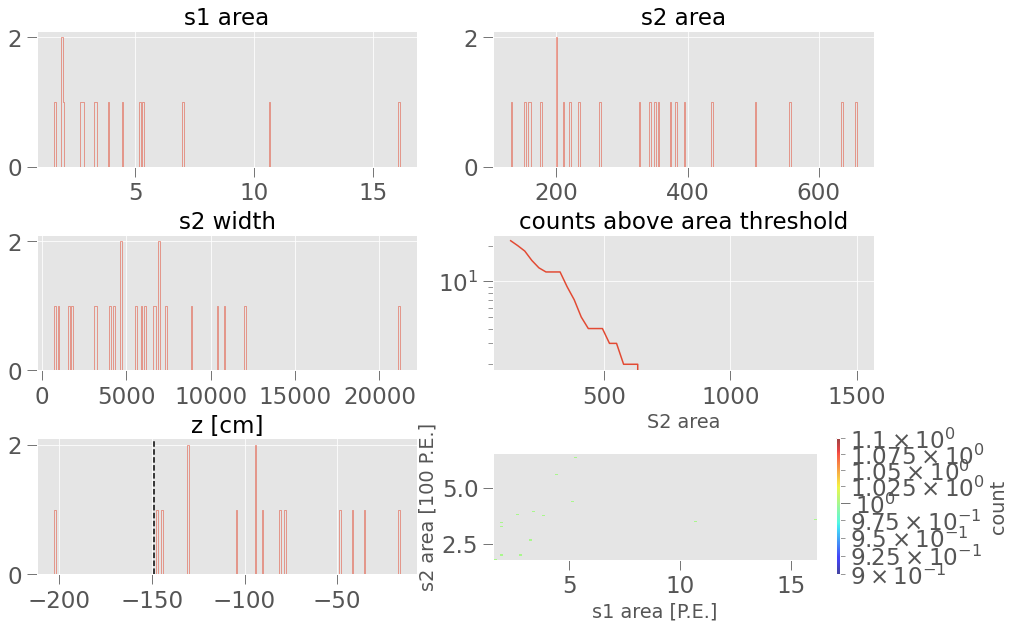

In [14]:
sn.sn_utils_plots.quality_plot(event_info)

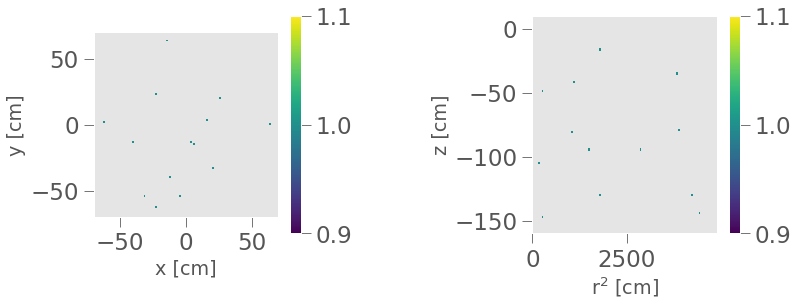

In [16]:
sn.sn_utils_plots.plot_xy_rz(event_info)

In [26]:
# st.data_info('event_info')['Field name'].values

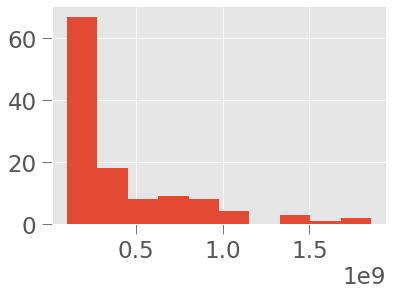

In [17]:
plt.hist(truth['time']);

---

**Ignore Below**<br>
Try automating batch jobs for future

In [30]:
multi_SN_path = os.path.join(sn.config["wfsim"]["instruction_path"], "SN_wfsim_test1.csv")

make_python_script(script_name='make_SN_data.py', fax_file=multi_SN_path, run_id='SN_multi',
                  strax_output_folder = sn.config["wfsim"]["strax_data_path"],)

In [31]:
jobstring = 'python3 make_SN_data.py'

In [34]:
from utilix import batchq

# batchq.submit_job(jobstring, dry_run=True)

In [38]:
sn.sn_utils.display_config() # 
sn.config['wfsim']['logs_path']

      xenonnt       
field
volume
lxe_density
drift_field
---------------
       paths        
imgs
data
---------------
       strax        
exclude_tags
---------------
       wfsim        
instruction_path
logs_path
strax_data_path
---------------


'/dali/lgrandi/melih/sn_wfsim/logs/'

In [47]:
def make_sbatch(jobname="SN_signal_prod", 
                std_output=sn.config['wfsim']['logs_path']+'SNoutput.out', 
                std_error=sn.config['wfsim']['logs_path']+'SNerr.err', 
                script='make_SN_data.py'):
    job_str = f"""#!/bin/bash
#SBATCH --qos=xenon1t
#SBATCH --partition=xenon1t
#SBATCH --job-name={jobname}
#SBATCH --output={std_output}
#SBATCH --error={std_error}
#SBATCH --account=pi-lgrandi
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem-per-cpu=16000
#SBATCH --time=12:00:00
module load singularity
singularity shell \
    --bind /cvmfs/ \
    --bind /project/ \
    --bind /project2/ \
    --bind /scratch/midway2/$USER \
    --bind /dali \
/project2/lgrandi/xenonnt/singularity-images/xenonnt-development.simg <<EOF
python {script}
EOF"""
    sbatch_name = script.replace('.py', '.sbatch')
    with open(sbatch_name, 'w') as f:
        f.write(job_str)

def make_python_script(script_name, fax_file, run_id,
                       strax_output_folder='./', 
                       make=('truth', 'peak_basics','event_info')):
    main_text = f"import wfsim, strax, straxen, cutax, ntauxfiles\n" +\
                f"straxen.print_versions(('strax','straxen','cutax','wfsim', 'multimessenger', 'ntauxfiles'),)\n"+\
                f"st = straxen.contexts.xenonnt_simulation( \n"+\
                "    wfsim_registry='RawRecordsFromFaxNT',\n"+\
                "    cmt_run_id_sim='026000',\n"+\
                "    cmt_run_id_proc='026000',\n"+\
                "    cmt_version='global_v7',\n"+\
                "    fax_config='/home/melih/software/private_nt_aux_files/sim_files/fax_config_nt_sr0_v0.json',\n"+\
                "    overwrite_from_fax_file_sim=True,\n"+\
                "    overwrite_from_fax_file_proc=True,\n"+\
                f"    output_folder='{strax_output_folder}')\n\n"+\
                f"st.set_config(dict(fax_file='{fax_file}'))\n"+\
                f"run_id = '{run_id}'\n"
    data = "\n"
    for m in make:
        data += f"st.make({run_id}, '{m}')\n"
    
    write_out = main_text + data
    with open(script_name, 'w') as f:
        f.write(write_out)
    make_sbatch(script=script_name)

In [48]:
make_python_script(script_name='make_SN_data.py', fax_file=multi_SN_path, run_id='SN_multi',
                  strax_output_folder = sn.config["wfsim"]["strax_data_path"],)